# Курсовой проект "Предсказание стоимости недвижимости"

**Подключение библиотек и скриптов**

In [813]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.decomposition import PCA
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [814]:
import warnings
warnings.filterwarnings('ignore')

In [815]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [816]:
matplotlib.rcParams.update({'font.size': 14})

In [817]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [818]:
TRAIN_DATASET_PATH = '/content/drive/My Drive/kurs_biblioteki_python/train.csv'
TEST_DATASET_PATH = '/content/drive/My Drive/kurs_biblioteki_python/test.csv'

## Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [819]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [820]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [821]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [822]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


## Приведение типов

In [823]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [824]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## EDA

**Распределение целевой переменной**

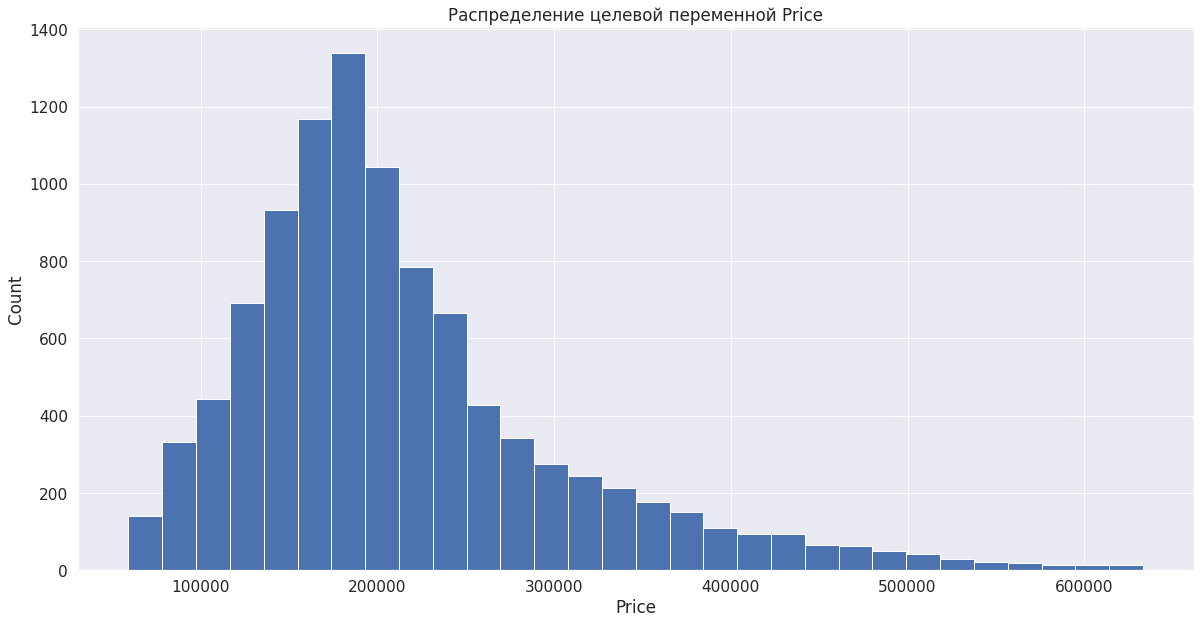

In [825]:
plt.figure(figsize=(20, 10))
train_df['Price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Распределение целевой переменной Price')
plt.show()

### Анализ признаков

**Количественные признаки**

In [826]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Категориальные признаки**

In [827]:
train_df.select_dtypes(include=['object'])

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,11809,27,B,B,B
1,3013,22,B,B,B
2,8215,1,B,B,B
3,2352,1,B,B,B
4,13866,94,B,B,B
...,...,...,...,...,...
9995,1260,61,B,B,B
9996,16265,27,B,B,A
9997,2795,178,B,B,B
9998,14561,21,B,B,B


### Обработка выбросов и пропусков

**Rooms**

In [828]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [829]:
train_df.loc[(train_df['Rooms'] > 5) | (train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**Square**

In [830]:
train_df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

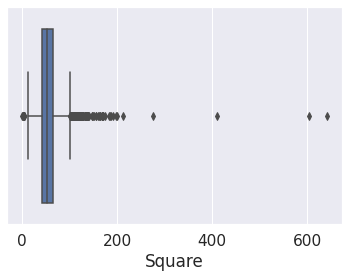

In [831]:
sns.boxplot(train_df['Square'], whis=1.5)
plt.xlabel('Square')
plt.show()

In [832]:
def condition(x):
    return (x < x.quantile(0.025)) | (x > x.quantile(0.975)) | (x.isna())

In [833]:
train_df.loc[condition(train_df['Square']), 'Square'] = train_df['Square'].median()

In [834]:
train_df['Square'].describe()

count    10000.000000
mean        55.108599
std         15.215053
min         32.105270
25%         42.432730
50%         52.513310
75%         64.591720
max        100.904263
Name: Square, dtype: float64

**KitchenSquare**

In [835]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [836]:
train_df.loc[(train_df['KitchenSquare'] >= train_df['Square']) | (condition(train_df['KitchenSquare'])), 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [837]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         5.536700
std          3.670668
min          0.000000
25%          1.000000
50%          6.000000
75%          8.000000
max         13.000000
Name: KitchenSquare, dtype: float64

**LifeSquare**

In [838]:
train_df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [839]:
train_df.loc[condition(train_df['LifeSquare']), 'LifeSquare'] = train_df['LifeSquare'].median()

In [840]:
train_df.loc[train_df['LifeSquare'] >= train_df['Square'], 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']

In [841]:
train_df['LifeSquare'].describe()

count    10000.000000
mean        34.304007
std         11.429333
min          5.927865
25%         27.613399
50%         32.781260
75%         39.328620
max         80.577260
Name: LifeSquare, dtype: float64

**HouseFloor**

In [842]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [843]:
train_df['HouseFloor'].quantile(0.975)

25.0

In [844]:
train_df.loc[(train_df['HouseFloor'] > 25) | (train_df['HouseFloor'] == 0), 'HouseFloor'] = train_df['HouseFloor'].median()

In [845]:
train_df['HouseFloor'].describe()

count    10000.000000
mean        12.815400
std          6.030154
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         25.000000
Name: HouseFloor, dtype: float64

**Floor**

In [846]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [847]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor']

**HouseYear**

In [848]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [849]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = train_df['HouseYear'].median()

**Ecology_1**

In [850]:
train_df['Ecology_1'].isna().sum()

0

**Ecology_2, Ecology_3, Shops_2**

In [851]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [852]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [853]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [854]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**Social_1, Social_2, Social_3**

In [855]:
train_df['Social_1'].isna().sum()

0

In [856]:
train_df['Social_2'].isna().sum()

0

In [857]:
train_df['Social_3'].isna().sum()

0

**Healthcare_1**

In [858]:
train_df['Healthcare_1'].isna().sum()

4798

In [859]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

**Helthcare_2**

In [860]:
train_df['Helthcare_2'].isna().sum()

0

**Shops_1**

In [861]:
train_df['Shops_1'].isna().sum()

0

In [862]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.modes=None
        self.binary_to_numbers=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()

        # Переход из категорий A/B в 0/1
        self.binary_to_numbers = {'A': 0, 'B': 1}
    
    def transform(self, X):
        """Трансформация данных"""

        def condition(a):
            return (a < a.quantile(0.025)) | (a > a.quantile(0.975)) | (a.isna())

        # Rooms
        X.loc[(X['Rooms'] > 5) | (X['Rooms'] == 0), 'Rooms'] = self.medians['Rooms']
        
        # Square
        X.loc[condition(X['Square']), 'Square'] = self.medians['Square']

        # KitchenSquare
        X.loc[(X['KitchenSquare'] >= X['Square']) | (condition(X['KitchenSquare'])),\
              'KitchenSquare'] = self.medians['KitchenSquare']

        # LifeSquare
        X.loc[condition(X['LifeSquare']), 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[X['LifeSquare'] >= X['Square'], 'LifeSquare'] = X['Square'] - X['KitchenSquare']
        
        # HouseFloor
        X.loc[(X['HouseFloor'] > X['HouseFloor'].quantile(0.975)) | (X['HouseFloor'] == 0),\
              'HouseFloor'] = self.medians['HouseFloor']
        
        # Floor
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X['HouseFloor']

        # HouseYear
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = self.medians['HouseYear']

        # Ecology_2, Ecology_3, Shops_2
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
            
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        return X

### Построение новых признаков

**LifeSquareRatio**

In [863]:
life_square_ratio = round(train_df['LifeSquare'] / train_df['Square'], 3)
train_df['LifeSquareRatio'] = life_square_ratio
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquareRatio
0,11809,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0.624
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0.582
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0.609
3,2352,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0.811
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0.600


**MedPriceByLifeSquareRatio**

In [864]:
med_price_by_life_square_ratio = train_df.groupby('LifeSquareRatio', as_index=False).agg({'Price':'median'})\
                                        .rename(columns={'Price':'MedPriceByLifeSquareRatio'})
train_df = train_df.merge(med_price_by_life_square_ratio, on=['LifeSquareRatio'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquareRatio,MedPriceByLifeSquareRatio
0,11809,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0.624,235065.357056
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0.582,217108.102688
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0.609,215400.473066
3,2352,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0.811,168401.903458
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0.600,208932.589347


**MedPriceBySocial_2District**

In [865]:
med_price_by_social_2_district = train_df.groupby(['DistrictId', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                        .rename(columns={'Price':'MedPriceBySocial_2District'})
train_df = train_df.merge(med_price_by_social_2_district, on=['DistrictId', 'Social_2'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquareRatio,MedPriceByLifeSquareRatio,MedPriceBySocial_2District
0,11809,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0.624,235065.357056,148315.419074
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0.582,217108.102688,186161.900526
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0.609,215400.473066,203858.095745
3,2352,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0.811,168401.903458,183882.806975
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0.600,208932.589347,201584.441255


**MedPriceByEcology_1District**

In [866]:
med_price_by_ecology_1_district = train_df.groupby(['DistrictId', 'Ecology_1'], as_index=False).agg({'Price':'median'})\
                                        .rename(columns={'Price':'MedPriceByEcology_1District'})
train_df = train_df.merge(med_price_by_ecology_1_district, on=['DistrictId', 'Ecology_1'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquareRatio,MedPriceByLifeSquareRatio,MedPriceBySocial_2District,MedPriceByEcology_1District
0,11809,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0.624,235065.357056,148315.419074,148315.419074
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0.582,217108.102688,186161.900526,186161.900526
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0.609,215400.473066,203858.095745,203858.095745
3,2352,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0.811,168401.903458,183882.806975,183882.806975
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0.600,208932.589347,201584.441255,201584.441255


**HouseYearCat**

In [867]:
def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [868]:
train_df = year_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquareRatio,MedPriceByLifeSquareRatio,MedPriceBySocial_2District,MedPriceByEcology_1District,year_cat
0,11809,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0.624,235065.357056,148315.419074,148315.419074,6
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0.582,217108.102688,186161.900526,186161.900526,3
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0.609,215400.473066,203858.095745,203858.095745,4
3,2352,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0.811,168401.903458,183882.806975,183882.806975,3
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0.600,208932.589347,201584.441255,201584.441255,3


**MedPriceByYearHelthcare_2**

In [869]:
med_price_by_year_helthcare_2 = train_df.groupby(['year_cat', 'Helthcare_2'], as_index=False).agg({'Price':'median'})\
                                        .rename(columns={'Price':'MedPriceByYearHelthcare_2'})
train_df = train_df.merge(med_price_by_year_helthcare_2, on=['year_cat', 'Helthcare_2'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquareRatio,MedPriceByLifeSquareRatio,MedPriceBySocial_2District,MedPriceByEcology_1District,year_cat,MedPriceByYearHelthcare_2
0,11809,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,0,0,1,305018.871089,0.624,235065.357056,148315.419074,148315.419074,6,153477.931533
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1,0,1,177734.553407,0.582,217108.102688,186161.900526,186161.900526,3,201857.341542
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,3,1,1,282078.720850,0.609,215400.473066,203858.095745,203858.095745,4,228489.712265
3,2352,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,0,1,1,168106.007630,0.811,168401.903458,183882.806975,183882.806975,3,167970.265127
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,0,6,1,343995.102962,0.600,208932.589347,201584.441255,201584.441255,3,167970.265127


In [870]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):

        self.life_square_ratio = None
        self.med_price_by_life_square_ratio = None
        self.med_price_by_social_2_district = None
        self.MedPriceByEcology_1District = None
        self.house_year_max = None
        self.MedPriceByYearHelthcare_2 = None

    def new_feature(self, X):

        ## Square, LifeSquare
        self.life_square_ratio = round(X['LifeSquare'] / X['Square'], 3)
        X['LifeSquareRatio'] = self.life_square_ratio

        return X

    def fit(self, X, y=None):
        
        df = X.copy()

        # Feature encoding
        ## Square, LifeSquare
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_life_square_ratio = df.groupby('LifeSquareRatio', as_index=False).agg({'Price':'median'})\
                                                    .rename(columns={'Price':'MedPriceByLifeSquareRatio'})
            self.med_price_by_life_square_ratio_median = self.med_price_by_life_square_ratio['MedPriceByLifeSquareRatio']\
                                                            .median()
        
        ## DistrictId, Social_2
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_social_2_district = df.groupby(['DistrictId', 'Social_2'], as_index=False).agg({'Price':'median'})\
                                                    .rename(columns={'Price':'MedPriceBySocial_2District'})
            self.med_price_by_social_2_district_median = self.med_price_by_social_2_district['MedPriceBySocial_2District']\
                                                            .median()
        
        ## DistrictId, Ecology_1
        if y is not None:
            self.med_price_by_ecology_1_district = df.groupby(['DistrictId', 'Ecology_1'], as_index=False)\
                                                .agg({'Price':'median'}).rename(columns={'Price':'MedPriceByEcology_1District'})
            self.med_price_by_ecology_1_district_median = self.med_price_by_ecology_1_district['MedPriceByEcology_1District']\
                                                            .median()

        ## Helthcare_2, HouseYear
        if y is not None:
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.year_to_cat(df)
            self.med_price_by_year_helthcare_2 = df.groupby(['year_cat', 'Helthcare_2'], as_index=False).agg({'Price':'median'})\
                                                    .rename(columns={'Price':'MedPriceByYearHelthcare_2'})
            self.med_price_by_year_helthcare_2_median = self.med_price_by_year_helthcare_2['MedPriceByYearHelthcare_2'].median()
              
    def transform(self, X):

        # More categorical features
        X = self.year_to_cat(X)
        
        # Target encoding
        if self.med_price_by_life_square_ratio is not None:
            X = X.merge(self.med_price_by_life_square_ratio, on=['LifeSquareRatio'], how='left')
            X.fillna(self.med_price_by_life_square_ratio_median, inplace=True)

        if self.med_price_by_social_2_district is not None:
            X = X.merge(self.med_price_by_social_2_district, on=['DistrictId', 'Social_2'], how='left')
            X.fillna(self.med_price_by_social_2_district_median, inplace=True)
            
        if self.med_price_by_ecology_1_district is not None:
            X = X.merge(self.med_price_by_ecology_1_district, on=['DistrictId', 'Ecology_1'], how='left')
            X.fillna(self.med_price_by_ecology_1_district_median, inplace=True)
        
        if self.med_price_by_year_helthcare_2 is not None:
            X = X.merge(self.med_price_by_year_helthcare_2, on=['year_cat', 'Helthcare_2'], how='left')
            X.fillna(self.med_price_by_year_helthcare_2_median, inplace=True)
        
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)

        return X

### Отбор признаков

In [871]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'LifeSquareRatio',
 'MedPriceByLifeSquareRatio',
 'MedPriceBySocial_2District',
 'MedPriceByEcology_1District',
 'year_cat',
 'MedPriceByYearHelthcare_2']

In [872]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['LifeSquareRatio', 'MedPriceByLifeSquareRatio', 'MedPriceBySocial_2District', 'MedPriceByEcology_1District',
                     'year_cat', 'MedPriceByYearHelthcare_2']

target_name = 'Price'

### Объединение признаков методом PCA (не повысило точность модели)

**Корреляционная матрица**

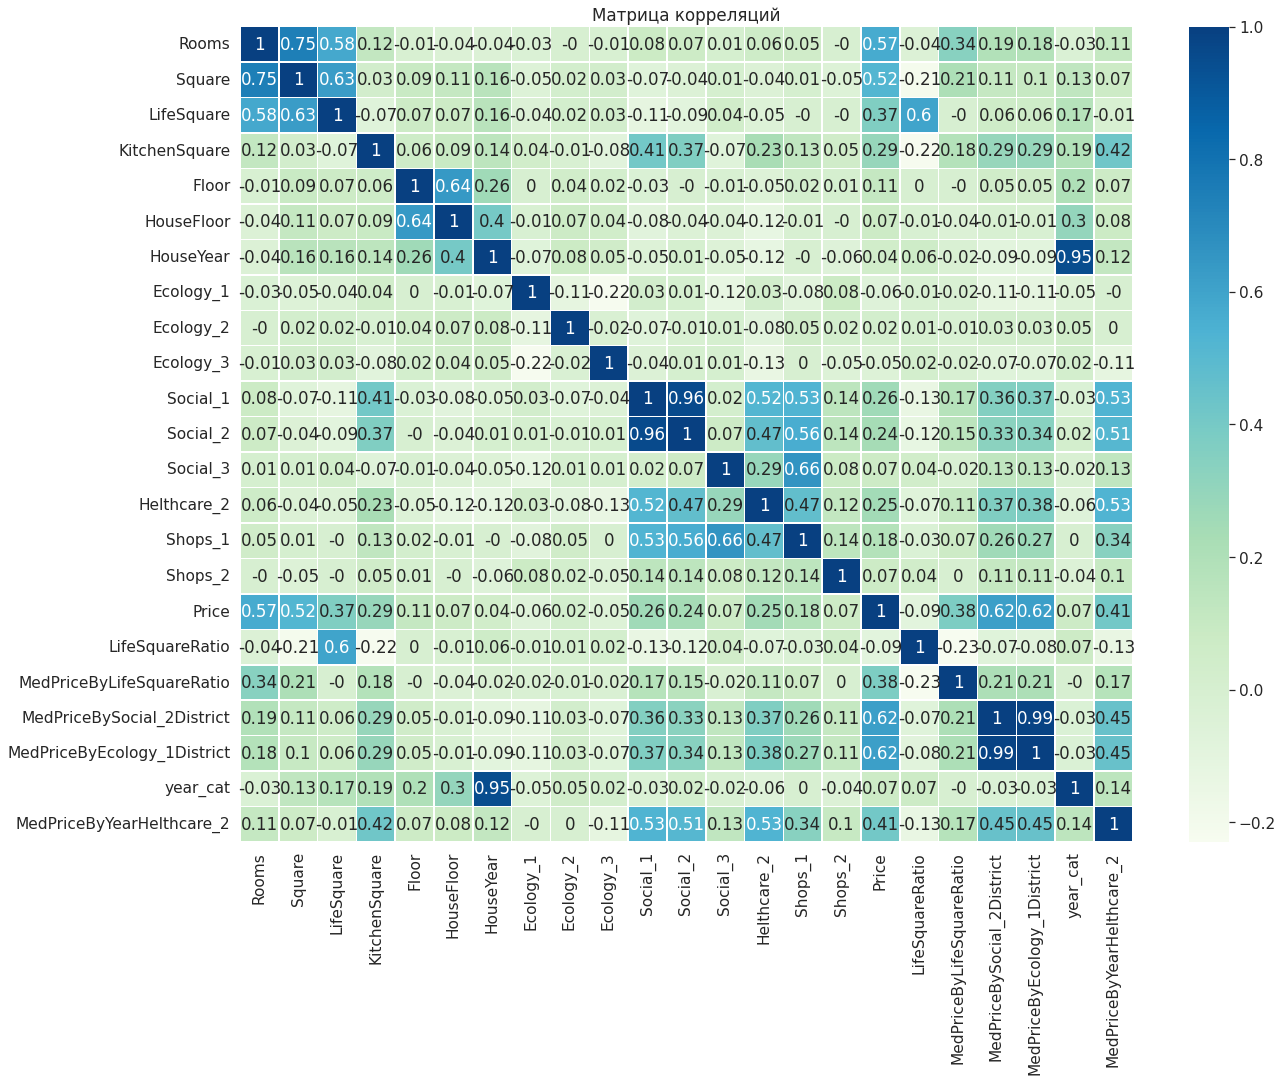

In [873]:
plt.figure(figsize=(20, 15))
sns.set(font_scale=1.4)
corr_matrix = np.round(train_df.corr(), 2)
sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap='GnBu')
plt.title('Матрица корреляций')
plt.show()

**Объединение Social_1 и Social_2**

In [874]:
pca = PCA(n_components=1, random_state=42)
new_comp1 = train_df[['Social_1', 'Social_2']]
new_comp1['new_comp1'] = pca.fit_transform(new_comp1)
train_df.insert(14,'Social_1_Social_2', new_comp1.new_comp1)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_1_Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquareRatio,MedPriceByLifeSquareRatio,MedPriceBySocial_2District,MedPriceByEcology_1District,year_cat,MedPriceByYearHelthcare_2
0,11809,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,-2255.194923,0,0,0,1,305018.871089,0.624,235065.357056,148315.419074,148315.419074,6,153477.931533
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,854.857346,1,1,0,1,177734.553407,0.582,217108.102688,186161.900526,186161.900526,3,201857.341542
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,-91.121828,0,3,1,1,282078.720850,0.609,215400.473066,203858.095745,203858.095745,4,228489.712265
3,2352,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,1,1,1,264,-5088.211968,0,0,1,1,168106.007630,0.811,168401.903458,183882.806975,183882.806975,3,167970.265127
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,3314.848372,2,0,6,1,343995.102962,0.600,208932.589347,201584.441255,201584.441255,3,167970.265127


**Объединение MedPriceBySocial_2District и MedPriceByEcology_1District**

In [875]:
new_comp2 = train_df[['MedPriceBySocial_2District', 'MedPriceByEcology_1District']]
new_comp2['new_comp2'] = pca.fit_transform(new_comp2)
train_df.insert(24,'MedPriceBySocial_2District_MedPriceByEcology_1District', new_comp2.new_comp2)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_1_Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquareRatio,MedPriceByLifeSquareRatio,MedPriceBySocial_2District,MedPriceByEcology_1District,MedPriceBySocial_2District_MedPriceByEcology_1District,year_cat,MedPriceByYearHelthcare_2
0,11809,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,-2255.194923,0,0,0,1,305018.871089,0.624,235065.357056,148315.419074,148315.419074,-79549.083761,6,153477.931533
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,854.857346,1,1,0,1,177734.553407,0.582,217108.102688,186161.900526,186161.900526,-26027.967628,3,201857.341542
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,-91.121828,0,3,1,1,282078.720850,0.609,215400.473066,203858.095745,203858.095745,-1002.652643,4,228489.712265
3,2352,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977,0.007122,1,1,1,264,-5088.211968,0,0,1,1,168106.007630,0.811,168401.903458,183882.806975,183882.806975,-29250.978750,3,167970.265127
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,3314.848372,2,0,6,1,343995.102962,0.600,208932.589347,201584.441255,201584.441255,-4217.972043,3,167970.265127


In [796]:
def new_components(X):
    pca = PCA(n_components=1, random_state=42)

    # Social_1 и Social_2
    new_comp1 = X[['Social_1', 'Social_2']]
    new_comp1['new_comp1'] = pca.fit_transform(new_comp1)
    X.insert(13,'Social_1_Social_2', new_comp1.new_comp1)

    # MedPriceBySocial_2District и MedPriceByEcology_1District
    new_comp2 = X[['MedPriceBySocial_2District', 'MedPriceByEcology_1District']]
    new_comp2['new_comp2'] = pca.fit_transform(new_comp2)
    X.insert(21,'MedPriceBySocial_2District_MedPriceByEcology_1District', new_comp2.new_comp2)

    X.drop(columns=['Social_1', 'Social_2'], axis=1, inplace=True)
    X.drop(columns=['MedPriceBySocial_2District', 'MedPriceByEcology_1District'], axis=1, inplace=True)

    return X

### Разбиение на train и test

In [876]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [877]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [878]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 18), (3300, 18), (5000, 18))

In [879]:
features_gen = FeatureGenetator()

features_gen.new_feature(X_train)
features_gen.new_feature(X_valid)
features_gen.new_feature(test_df)

features_gen.fit(X_train, y_train)
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [880]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [881]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [882]:
# С применением PCA точность ниже
# X_train = new_components(X_train)
# X_valid = new_components(X_valid)
# test_df = new_components(test_df)

### Построение модели

**Обучение модели**

In [883]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

**Оценка модели**

Train R2:	0.964
Test R2:	0.716


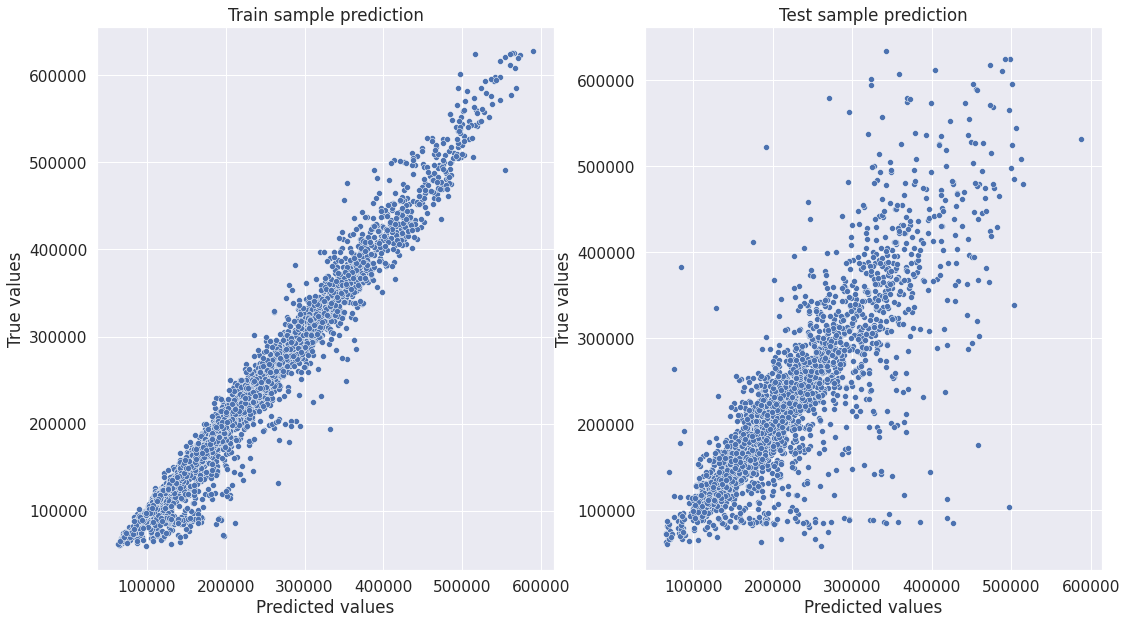

In [884]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [885]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75010344, 0.70797668, 0.73108319])

In [886]:
cv_score.mean()

0.7297211024220881

**Важность признаков**

In [887]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceBySocial_2District,0.205838
0,Rooms,0.194291
1,Square,0.176824
19,MedPriceByEcology_1District,0.142995
17,MedPriceByLifeSquareRatio,0.049051
21,MedPriceByYearHelthcare_2,0.034712
12,Social_3,0.024738
6,HouseYear,0.024602
2,LifeSquare,0.022347
16,LifeSquareRatio,0.020424


### Прогнозирование на тестовом датасете

In [888]:
test_df.shape

(5000, 22)

In [889]:
submit = pd.read_csv('/content/drive/My Drive/kurs_biblioteki_python/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [890]:
predictions = rf_model.predict(test_df)
predictions

array([161444.44413401, 124001.19760574, 137442.81508792, ...,
       144769.8791362 , 204084.14471444, 230961.9716494 ])

In [891]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161444.444134
1,5925,124001.197606
2,960,137442.815088
3,3848,176660.127565
4,746,139505.237487


In [892]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifeSquareRatio,MedPriceByLifeSquareRatio,MedPriceBySocial_2District,MedPriceByEcology_1District,year_cat,MedPriceByYearHelthcare_2
0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970.0,0.036122,1,1,24,4378,0,1,1,1,0.518,176597.298103,202526.486861,202526.486861,2,201362.265611
1,1.0,42.493907,32.493907,10.0,7.0,17.0,2017.0,0.072158,1,1,2,629,1,0,0,0,0.765,138873.641103,157190.771131,157190.771131,5,155631.325204
2,2.0,59.463678,32.679351,9.0,19.0,19.0,1977.0,0.211401,1,1,9,1892,0,0,1,1,0.550,206730.910184,119817.448457,119817.448457,2,167599.468617
3,3.0,49.646030,33.893825,6.0,2.0,2.0,1965.0,0.014073,1,1,2,475,0,0,0,1,0.683,224179.311825,111207.565421,111207.565421,2,167599.468617
4,1.0,53.837056,32.679351,1.0,8.0,17.0,1977.0,0.309479,1,1,35,7715,4,0,6,1,0.607,219795.119082,156028.369596,156028.369596,2,167599.468617


In [894]:
submit.to_csv('rf_submit.csv', index=False)

### AutoML

In [350]:
!pip install lightautoml

     |████████████████████████████████| 293 kB 8.5 MB/s 
     |████████████████████████████████| 1.2 MB 40.7 MB/s 
     |████████████████████████████████| 76.3 MB 15 kB/s 
     |████████████████████████████████| 308 kB 55.9 MB/s 
     |████████████████████████████████| 204 kB 65.6 MB/s 
     |████████████████████████████████| 804.1 MB 1.6 kB/s 
     |████████████████████████████████| 15.7 MB 1.2 MB/s 
     |████████████████████████████████| 424 kB 54.7 MB/s 
     |████████████████████████████████| 2.8 MB 43.3 MB/s 
     |████████████████████████████████| 80 kB 7.7 MB/s 
     |████████████████████████████████| 209 kB 46.8 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 49 kB 4.5 MB/s 
     |████████████████████████████████| 111 kB 56.6 MB/s 
     |████████████████████████████████| 144 kB 57.1 MB/s 
     |████████████████████████████████| 23.3 MB 78 kB/s 
     |████████████████████████████████| 22.1 MB 1.6 MB/s 
     |████████████████

In [895]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error

In [896]:
TASK = Task('reg', loss='mse', metric=mean_quantile_error, greater_is_better=False)
TIMEOUT = 300000
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TARGET_NAME = 'Price'
TEST_SIZE=0.2

In [897]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)


preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

X_train = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

features_gen = FeatureGenetator()
features_gen.new_feature(X_train)
features_gen.new_feature(X_valid)
features_gen.new_feature(test_df)
features_gen.fit(X_train, X_train[TARGET_NAME])

X_train = features_gen.transform(X_train)
test_df = features_gen.transform(test_df)

# С применением PCA точность ниже
# X_train = new_components(X_train)
# test_df = new_components(test_df)

In [898]:
roles = {'target': TARGET_NAME, 'drop': ['Id']}

In [899]:
automl_model = TabularAutoML(task=TASK,
                            timeout=TIMEOUT,
                            cpu_limit = N_THREADS,
                            gpu_ids='all',
                            reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                            general_params={'use_algos': [['lgb_tuned', 'cb_tuned', 'cb'],['lgb_tuned', 'cb']]},
                            tuning_params={'max_tuning_iter': 10},
                      )

In [900]:
oof_pred = automl_model.fit_predict(X_train, roles = roles)

In [901]:
test_df['Price'] = automl_model.predict(test_df).data

In [902]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,LifeSquareRatio,year_cat,MedPriceByLifeSquareRatio,MedPriceBySocial_2District,MedPriceByEcology_1District,MedPriceByYearHelthcare_2,Price
0,4567,44,1.0,36.847630,19.094182,5.0,5.0,9.0,1970.0,0.036122,1,1,24,4378,0,1,1,1,0.518,2,173432.859773,201895.819112,201895.819112,201857.341542,159392.093750
1,5925,62,1.0,42.493907,32.493907,10.0,7.0,17.0,2017.0,0.072158,1,1,2,629,1,0,0,0,0.765,5,139622.291959,157190.771131,157190.771131,153477.931533,120166.476562
2,960,27,2.0,59.463678,32.781260,9.0,19.0,19.0,1977.0,0.211401,1,1,9,1892,0,0,1,1,0.551,2,192727.092419,117527.890262,117527.890262,167970.265127,137984.531250
3,3848,23,3.0,49.646030,33.893825,6.0,2.0,2.0,1965.0,0.014073,1,1,2,475,0,0,0,1,0.683,2,250099.765683,118250.845397,118250.845397,167970.265127,156185.937500
4,746,74,1.0,53.837056,32.781260,1.0,8.0,17.0,1977.0,0.309479,1,1,35,7715,4,0,6,1,0.609,2,215400.473066,179291.591793,179291.591793,167970.265127,165127.312500


In [903]:
test_df.to_csv('submission.csv', columns=['Id', 'Price'], index=False)

### GradientBoosting

In [362]:
# Точность модели ниже остальных
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [363]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [364]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 18), (3300, 18), (5000, 18))

In [365]:
features_gen = FeatureGenetator()

features_gen.new_feature(X_train)
features_gen.new_feature(X_valid)
features_gen.new_feature(test_df)

features_gen.fit(X_train, y_train)
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 24), (3300, 24), (5000, 24))

In [367]:
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=21, criterion='mse')
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Train R2:	0.782
Test R2:	0.693


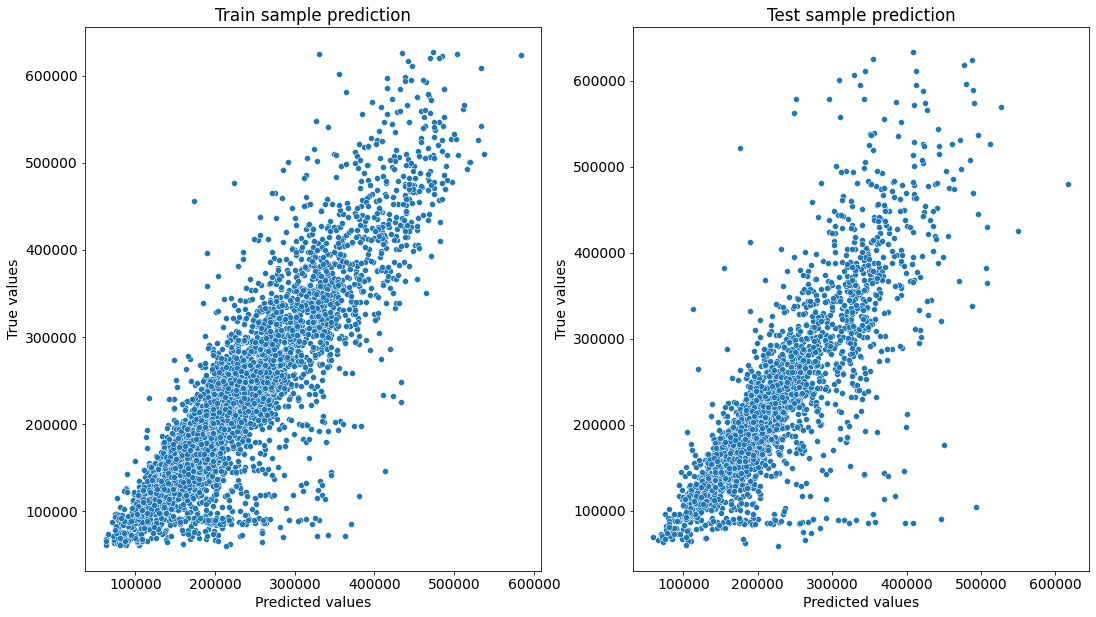

In [377]:
y_train_preds2 = gb_model.predict(X_train)
y_test_preds2 = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds2, y_valid, y_test_preds2)

In [378]:
cv_score2 = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score2

array([0.72986239, 0.70063375, 0.72471303])

In [379]:
cv_score2.mean()

0.7184030565905445

In [380]:
submit2 = pd.read_csv('/content/drive/My Drive/kurs_biblioteki_python/sample_submission.csv')
submit2.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [381]:
predictions2 = gb_model.predict(test_df)
predictions2

array([157337.18254114, 122350.34138376, 146214.22915876, ...,
       152675.09191904, 203471.50743749, 223359.18456766])

In [382]:
submit2['Price'] = predictions
submit2.head()

,Id,Price
0,4567,157337.182541
1,5925,122350.341384
2,960,146214.229159
3,3848,165965.774829
4,746,160947.165799


In [383]:
submit2.to_csv('gb_submit.csv', index=False)